In [1]:
import random 
import os
import sys 

In [2]:
import numpy as np 
import cv2
import json 
from pathlib import Path
import matplotlib.pyplot as plt 

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog,MetadataCatalog

from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

### Registor dataset

In [5]:
data_dir = Path("../imaterialist-fashion-2020-fgvc7")
train_json_path = os.path.join(data_dir, 'train.json')
validation_json_path = os.path.join(data_dir, 'validation.json')

In [6]:
train_data_name = 'fashion_train'
val_data_name = 'fashion_val'


register_coco_instances(train_data_name, {}, train_json_path, os.path.join(data_dir, 'train') )
register_coco_instances(val_data_name, {}, validation_json_path, os.path.join(data_dir, 'train') )

### Visualize train dataset
* to verify the data loading is correct 

[06/01 17:53:24 d2.data.datasets.coco]: Loading ../imaterialist-fashion-2020-fgvc7/train.json takes 15.76 seconds.
WARNING [06/01 17:53:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/01 17:53:25 d2.data.datasets.coco]: Loaded 41060 images in COCO format from ../imaterialist-fashion-2020-fgvc7/train.json
Path: ../imaterialist-fashion-2020-fgvc7/train/4ffcfcaeb3afa7d366696d197f01d067.jpg
(3264, 4912, 3)
Height:  3264
Width:  4912


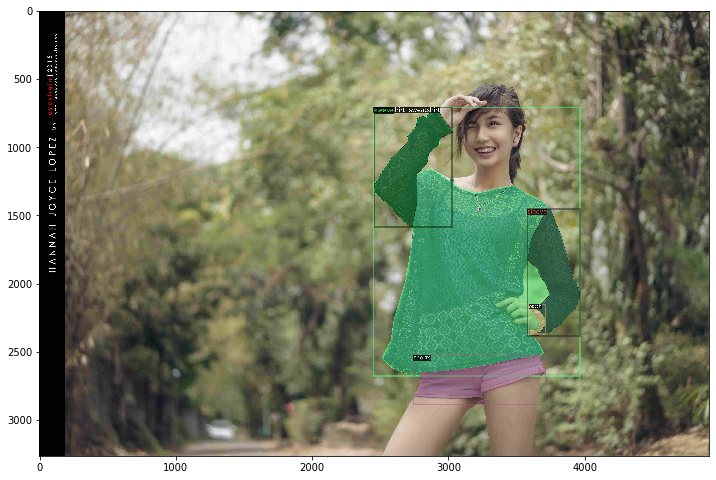

Path: ../imaterialist-fashion-2020-fgvc7/train/ea6df97b08a8c96a9587abe7764f9cc3.jpg
(2048, 1365, 3)
Height:  2048
Width:  1365


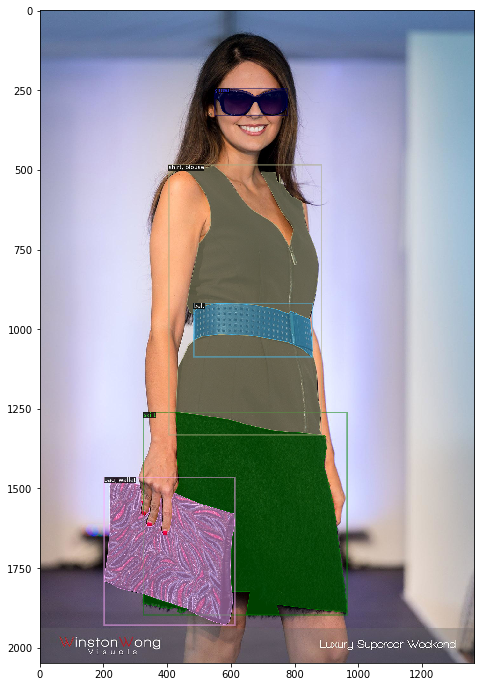

Path: ../imaterialist-fashion-2020-fgvc7/train/c3050264e5208e8f4797ec3391fd19cd.jpg
(1000, 618, 3)
Height:  1000
Width:  618


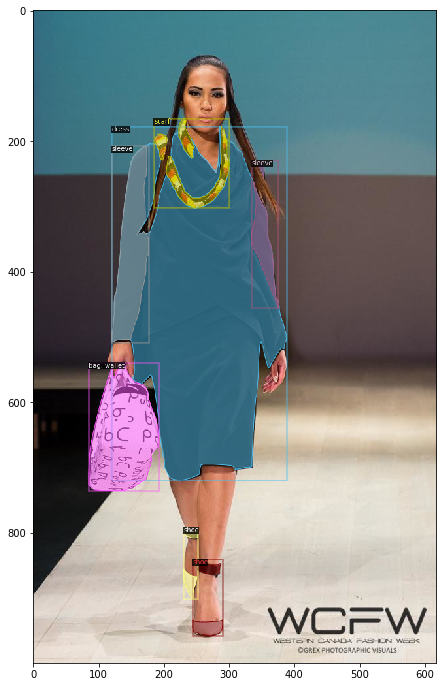

In [7]:
train_metadata = MetadataCatalog.get(train_data_name)

dataset_dicts = DatasetCatalog.get(name=train_data_name)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    
    print("Path:",d["file_name"] )
    print(img.shape)
    print("Height: ",d["height"] )
    print("Width: ", d["width"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

## Set Config and Import model files 

In [11]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (train_data_name,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 46  # only has one class (ballon)

## Training 

In [12]:
# update create ouptput directory 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [13]:
# training

# Create a trainer instance with the configuration.
trainer = DefaultTrainer(cfg) 

[06/01 17:54:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/01 17:54:51 d2.data.datasets.coco]: Loading ../imaterialist-fashion-2020-fgvc7/train.json takes 18.88 seconds.
WARNING [06/01 17:54:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/01 17:54:51 d2.data.datasets.coco]: Loaded 41060 images in COCO format from ../imaterialist-fashion-2020-fgvc7/train.json
[06/01 17:54:55 d2.data.build]: Removed 0 images with no usable annotations. 41060 images left.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[06/01 17:55:56 d2.data.common]: Serializing 41060 elements to byte tensors and concatenating them all ...
[06/01 17:55:58 d2.data.common]: Serialized dataset takes 421.78 MiB
[06/01 17:55:58 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[06/01 17:55:58 d2.data.build]: Using training sampler TrainingSampler


In [14]:
# if resume=False, because we don't have trained model yet. It will download model from model url and load it
trainer.resume_or_load(resume=False)

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (47, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (47,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (184, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (184,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (46, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (46,) in the model! Skipped.


In [15]:
# start training
trainer.train()

[06/01 17:56:01 d2.engine.train_loop]: Starting training from iteration 0
ERROR [06/01 17:56:01 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/detectron2/engine/train_loop.py", line 132, in train
    self.run_step()
  File "/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/detectron2/engine/train_loop.py", line 215, in run_step
    loss_dict = self.model(data)
  File "/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/detectron2/modeling/meta_arch/rcnn.py", line 130, in forward
    _, detector_losses = self.roi_heads(images, features, proposals, gt_instances)
  File "/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/nn/modules/module.py", line 550, in _

RuntimeError: CUDA error: an illegal memory access was encountered

In [ ]:
# Look at training cruves in  tensorboard: 
%load_ext tensorboard
%tensorboard --logdir output